# TP 3:  

### import libraries 

In [1]:
import os
import numpy                       as np
import powerlaw                    as pl
import matplotlib.pyplot           as plt
import pandas                      as pd
from   matplotlib.ticker           import PercentFormatter
from   scipy.stats                 import kstest,chisquare,poisson,expon,linregress
import statsmodels.api             as sm

plt.style.use('ggplot')

### Question I

In [2]:
def simulate_homogeneous_Poison_with_interval_times(mu,T,method='Exp'):
    jump_time = [0]
    s = np.random.exponential(scale=mu) if method == 'Exp' else -np.log(np.random.uniform())/mu 
    while jump_time[-1] + s < T:
        jump_time.append(jump_time[-1] + s)
        s = np.random.exponential(scale=mu) if method == 'Exp' else -np.log(np.random.uniform())/mu 
    return(jump_time)

def simulate_homogeneous_Poison_with_order_statisctis(mu,T):
    n = np.random.poisson(lam=mu*T)
    jump_time = np.random.uniform(low=0,high=T,size=n)
    jump_time = np.sort(jump_time)
    jump_time = np.concatenate(([0],jump_time))
    return(jump_time)

def Jump_process_construction(jump_time):
    N = np.ones_like(jump_time)
    N[0] = 0
    N = N.cumsum()
    return(N)

def get_differences(lst):
    differences = []
    for i in range(len(lst) - 1):
        differences.append(lst[i+1] - lst[i])
    return differences
    
def perform_ks_test(sample):
    ks_statistic, p_value = kstest(sample, expon.cdf)

    return ks_statistic, p_value

def perform_chi_squared_test(sample, expected_counts):
    # Normalize 
    observed_counts_norm = sample / np.sum(sample)
    expected_counts_norm = expected_counts / np.sum(expected_counts)

    chi_squared_statistic, p_value = chisquare(observed_counts_norm, f_exp=expected_counts_norm)

    return chi_squared_statistic, p_value

def lamda(t,data):
    """ 
    t: must be in seconds
    """
    T = data['time'].max()
    assert (t/60)<=T , f"Exceded the highest possible value for t, should be in seconds and below {T}"
    # Change the 5 according to the frequency
    return(data[(data['time']>(t/60)-5) & (data['time']<=(t/60))]['intensity'].iloc[0])

def simulate_none_homogeneous_Poison(data,T):
    mu = data['intensity'].max()
    jump_time = simulate_homogeneous_Poison_with_order_statisctis(mu=mu,T=T)[1:]
    lamda_jump = np.array([lamda(t,data=data)/mu for t in jump_time])
    u = np.random.uniform(low=0,high=1,size=len(lamda_jump))
    return(jump_time[lamda_jump>=u])

def integrate_piecewise_constant_function(dataframe, T):
    data_array = dataframe.values
    
    x_values = data_array[:, 0]
    fx_values = data_array[:, 1]
    
    integral_value = 0
    for i in range(len(x_values) - 1):
        x_i = x_values[i]
        x_next = x_values[i + 1]
        

        f_i = fx_values[i]
        

        segment_integral = f_i * (min(x_next, T) - x_i)

        integral_value += segment_integral
        
        if x_next >= T:
            break
    
    return integral_value



#### 1. Time-homogeneous Poisson process

1.1 Implement the two proposed algorithms to simulate a time-homogeneous Poisson process with intensity µ on a time interval [0,T]

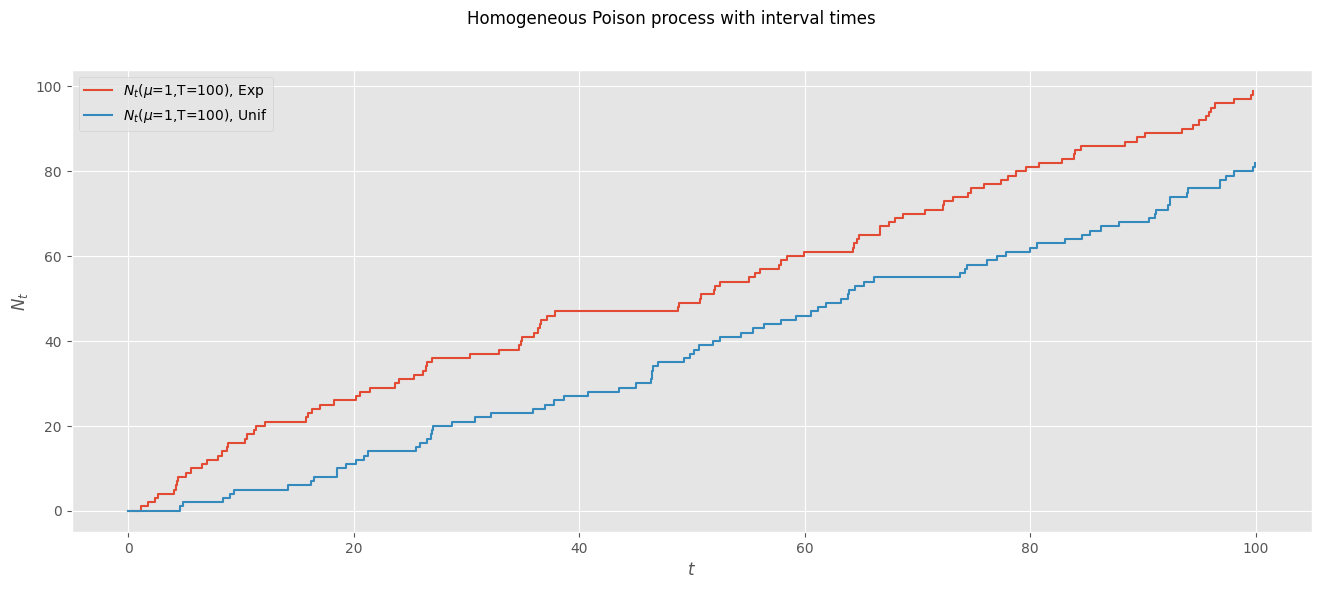

In [3]:
mu = 1
T = 100

fig, ax = plt.subplots(figsize=(16,6))
fig.suptitle(r'Homogeneous Poison process with interval times')

jump_time  = simulate_homogeneous_Poison_with_interval_times(mu=mu,T=T,method='Exp')
jump_value = Jump_process_construction(jump_time)
ax.step(jump_time,jump_value,label=r'$N_t$($\mu$='+f'{mu}'+',T='+f'{T}'+'), Exp',where='post')

jump_time  = simulate_homogeneous_Poison_with_interval_times(mu=mu,T=T,method='Uni')
jump_value = Jump_process_construction(jump_time)
ax.step(jump_time,jump_value,label=r'$N_t$($\mu$='+f'{mu}'+',T='+f'{T}'+'), Unif',where='post')

ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$N_t$')
ax.legend()

plt.show()

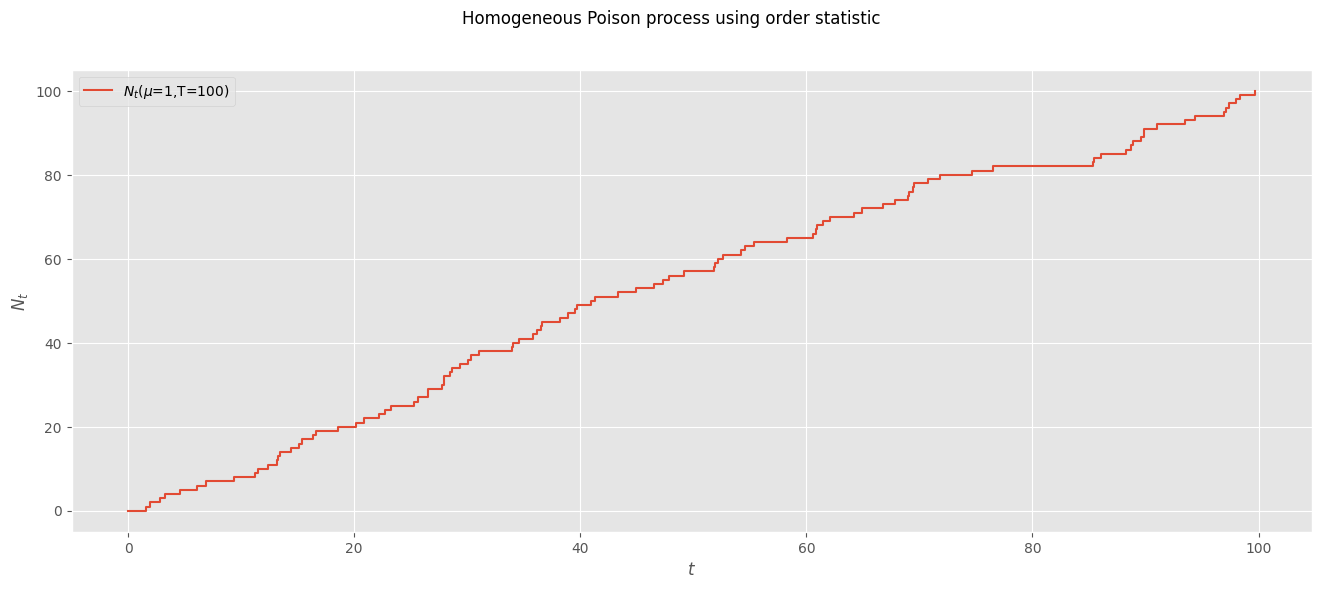

In [4]:
mu = 1
T = 100

fig, ax = plt.subplots(figsize=(16,6))
fig.suptitle(r'Homogeneous Poison process using order statistic')

jump_time  = simulate_homogeneous_Poison_with_order_statisctis(mu=mu,T=T)
jump_value = Jump_process_construction(jump_time)
ax.step(jump_time,jump_value,label=r'$N_t$($\mu$='+f'{mu}'+',T='+f'{T}'+')',where='post')

ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$N_t$')
ax.legend()

plt.show()

* Comments
    - We notice that the price is the same at the end of the weeek.
    - Over a month the price is between Low = 59 and High = 63
    - we notice big price jumps on the 3rd, 18th, 25th, and 26th on Juanary 2017
    - we notice that usually there are two jsmall jumps per day (*Open* and *Closing* moments) which can be explain by the price converging the optimal price 

1.2 Propose a quick sanity check for each algorithm.

To check the relevance of these results we propose to perform the following sanity checks:
- Checking that each $T_i$ is Gamma distributed with shape parameter n and rate parameter $\lambda$ $\quad i \in\left\{1, \ldots n\right\}$
- Checking that each $T_i - T_{i-1} $ are exponentially distributed with parameter $\lambda$ and are mutually independant $\quad i \in\left\{2, \ldots n\right\}$
- Checking that $N_t$ is Poisson distributed with parameter $\lambda t$ $\quad t \in [0,T]$, in particular we can check the property for $N_T$
- Checking that $N_1$, $N_2-N_1$, $\dots$ , $N_{t_n}-N_{t_{n-1}}$ are mutually independant 

In this case we are going to use 2  to test the statistical order method and 3 to testg time interval methoed

Test 1: **The KS statistic** (Kolmogorov-Smirnov statistic) 
</br> represents the maximum absolute distance between the empirical cumulative distribution function (ECDF) of the sample data and the cumulative distribution function (CDF) of the theoretical distribution.

-   If the *KS statistic is small* and the *p-value is high*, it suggests that **the sample data closely follows the theoretical distribution**.
-   If the *KS statistic is large* and the *p-value is low*, it indicates that the **sample data significantly deviates from the theoretical** distribution.

In [5]:
mu = 1
T = 10000

jump_time  = simulate_homogeneous_Poison_with_order_statisctis(mu=mu,T=T)
duration   = get_differences(jump_time) 

ks_statistic, p_value = perform_ks_test(duration)

print("Kolmogorov-Smirnov Test:")
print("KS Statistic:", f'{ks_statistic:.4f}')
print("p-value:", f'{p_value:.2%}')
if p_value < 0.05:
    print("Reject null hypothesis: Sample does not follow an exponential distribution")
else:
    print("Fail to reject null hypothesis: Sample follows an exponential distribution")

Kolmogorov-Smirnov Test:
KS Statistic: 0.0065
p-value: 78.46%
Fail to reject null hypothesis: Sample follows an exponential distribution


In [6]:
mu = 1
T = 10000

jump_time  = simulate_homogeneous_Poison_with_interval_times(mu=mu,T=T)
duration   = get_differences(jump_time) 

sample = mu*duration
ks_statistic, p_value = perform_ks_test(sample)

print("Kolmogorov-Smirnov Test:")
print("KS Statistic:", f'{ks_statistic:.4f}')
print("p-value:", f'{p_value:.2%}')
if p_value < 0.05:
    print("Reject null hypothesis: Sample does not follow an exponential distribution")
else:
    print("Fail to reject null hypothesis: Sample follows an exponential distribution")

Kolmogorov-Smirnov Test:
KS Statistic: 0.0080
p-value: 55.84%
Fail to reject null hypothesis: Sample follows an exponential distribution


In [7]:
mu = 1
T = 10000

jump_time  = simulate_homogeneous_Poison_with_interval_times(mu=mu,T=T,method='Uni')
duration   = get_differences(jump_time) 
sample = mu*duration
ks_statistic, p_value = perform_ks_test(sample)

print("Kolmogorov-Smirnov Test:")
print("KS Statistic:", f'{ks_statistic:.4f}')
print("p-value:", f'{p_value:.2%}')
if p_value < 0.05:
    print("Reject null hypothesis: Sample does not follow an exponential distribution")
else:
    print("Fail to reject null hypothesis: Sample follows an exponential distribution")

Kolmogorov-Smirnov Test:
KS Statistic: 0.0112
p-value: 15.70%
Fail to reject null hypothesis: Sample follows an exponential distribution


Test 2: **$\chi_2$ Test**

In [8]:
# Parameters
M = 1000 # Number of simulation
mu = 1
T = 100

Values = []
for _ in range(M):
    jump_time = simulate_homogeneous_Poison_with_interval_times(mu=mu,T=T)
    Values.append(len(jump_time)-1)
sample = np.array(Values)
unique_values, observed_counts = np.unique(sample, return_counts=True)
expected_counts = poisson.pmf(unique_values, mu=mu*T) * M

chi_squared_statistic, p_value = perform_chi_squared_test(observed_counts, expected_counts)

print("Chi-squared Test:")
print("Chi-squared Statistic:",  f'{chi_squared_statistic:.4f}')
print("p-value:", f'{p_value:.2%}')
if p_value < 0.05:
    print("Reject null hypothesis: Sample does not follow a Poisson distribution")
else:
    print("Fail to reject null hypothesis: Sample follows a Poisson distribution")

Chi-squared Test:
Chi-squared Statistic: 0.0475
p-value: 100.00%
Fail to reject null hypothesis: Sample follows a Poisson distribution


In [9]:
# Parameters
M = 1000 # Number of simulation
mu = 1
T = 100

Values = []
for _ in range(M):
    jump_time = simulate_homogeneous_Poison_with_interval_times(mu=mu,T=T,method='Uni')
    Values.append(len(jump_time)-1)
sample = np.array(Values)
unique_values, observed_counts = np.unique(sample, return_counts=True)
expected_counts = poisson.pmf(unique_values, mu=mu*T) * M

chi_squared_statistic, p_value = perform_chi_squared_test(observed_counts, expected_counts)

print("Chi-squared Test:")
print("Chi-squared Statistic:",  f'{chi_squared_statistic:.4f}')
print("p-value:", f'{p_value:.2%}')
if p_value < 0.05:
    print("Reject null hypothesis: Sample does not follow a Poisson distribution")
else:
    print("Fail to reject null hypothesis: Sample follows a Poisson distribution")

Chi-squared Test:
Chi-squared Statistic: 0.0600
p-value: 100.00%
Fail to reject null hypothesis: Sample follows a Poisson distribution


In [10]:
# Parameters
M = 1000 # Number of simulation
mu = 1
T = 100

Values = []
for _ in range(M):
    jump_time = simulate_homogeneous_Poison_with_order_statisctis(mu=mu,T=T)
    Values.append(len(jump_time)-1)
sample = np.array(Values)
unique_values, observed_counts = np.unique(sample, return_counts=True)
expected_counts = poisson.pmf(unique_values, mu=mu*T) * M

chi_squared_statistic, p_value = perform_chi_squared_test(observed_counts, expected_counts)

print("Chi-squared Test:")
print("Chi-squared Statistic:",  f'{chi_squared_statistic:.4f}')
print("p-value:", f'{p_value:.2%}')
if p_value < 0.05:
    print("Reject null hypothesis: Sample does not follow a Poisson distribution")
else:
    print("Fail to reject null hypothesis: Sample follows a Poisson distribution")

Chi-squared Test:
Chi-squared Statistic: 0.1266
p-value: 100.00%
Fail to reject null hypothesis: Sample follows a Poisson distribution


1.3 Compare the computational cost of each algorithm

In [11]:
%%timeit
simulate_homogeneous_Poison_with_order_statisctis(mu=1,T=1000)

58.6 µs ± 1.41 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [12]:
%%timeit
simulate_homogeneous_Poison_with_interval_times(mu=1,T=1000)

971 µs ± 56.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


* Comments
    - in the plot above we plot the evolution of the price during 7 min on the 31th of January.
    - we notice the presence of small jumps and begger jumps. Usually the sammler jumps correspend to moving from a bid/ask order to an other 

#### 2. A non-homogeneous Poisson process for trades

Import Data

In [13]:
folder_path = './Data/BNPP.PA'
frequency = 5*60 #seconds
file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and 'trades' in f]

df_trades = pd.DataFrame()

for f in file_names:

    gzip_file_path = folder_path+'/'+f
    df = pd.read_csv(gzip_file_path, compression='gzip',index_col=None)
    del df['Unnamed: 0']
    df['ts'] = pd.to_datetime(df['ts'])

    df = df[['ts']]
    df = df.drop_duplicates()
    df.set_index('ts', inplace=True)
    count_per_interval = df.resample('5min').size()
    data = pd.DataFrame(count_per_interval,columns=['Count'])
    data.reset_index(inplace=True)
    data['ts'] = data['ts'].dt.time
    
    df_trades = pd.concat([df_trades,data])



In [14]:
folder_path = './Data/BNPP.PA'
frequency = 5*60 #seconds
file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and 'trades' in f]

Duration_values = np.array([])

for f in file_names:

    gzip_file_path = folder_path+'/'+f
    df = pd.read_csv(gzip_file_path, compression='gzip',index_col=None)
    del df['Unnamed: 0']
    df['ts'] = pd.to_datetime(df['ts'])
    df_duration = pd.DataFrame({'ts':df['ts'].unique()})
    df_duration['duration'] = df_duration['ts'] - df_duration['ts'].shift(1)
    df_duration.dropna(inplace=True)
    df_duration['duration'] =   (df_duration['duration'].astype('int64') / 10**6).astype('int64')
    Duration_values = np.concatenate([Duration_values,df_duration['duration'].values]) 



2.1 Compute the average of the daily intensity of trades

We consider a counting process $N_t$ such that it is a non-homogeneous Poisson process $\mathcal{P}(\lambda(t))$.
This leads to $$N_{T_i} - N_{T_{i-1}} \sim \mathcal{P}(\Lambda(T_i)-\Lambda(T_{i-1}))$$

with $$E[N_{T_i} - N_{T_{i-1}}] = \Lambda(T_i)-\Lambda(T_{i-1}) = \int_{T_{i-1}}^{T_i} \lambda(t) \,dt  = \lambda_i (T_i-T_{i-1})$$
since $\lambda(t) = \sum_{i=1}^{n} \lambda_i $

*Conclusion*

$$\lambda_i = \frac{E[N_{T_i} - N_{T_{i-1}}]}{T_i-T_{i-1}}$$

et $E[N_{T_i} - N_{T_{i-1}}]$ estimer par les données de marché

In [15]:
df_trades_counts =  df_trades.groupby('ts').agg(Count=('Count','mean'))
df_trades_counts['intensity'] = df_trades_counts['Count']/(5*60) #5 min in seconds the intensity Lambda is trades/s
df_trades_counts

data_lamda = df_trades_counts[['intensity']]
data_lamda['time'] = [5*i for i in range(len(data_lamda))]
data_lamda['time in s'] = data_lamda['time']*60


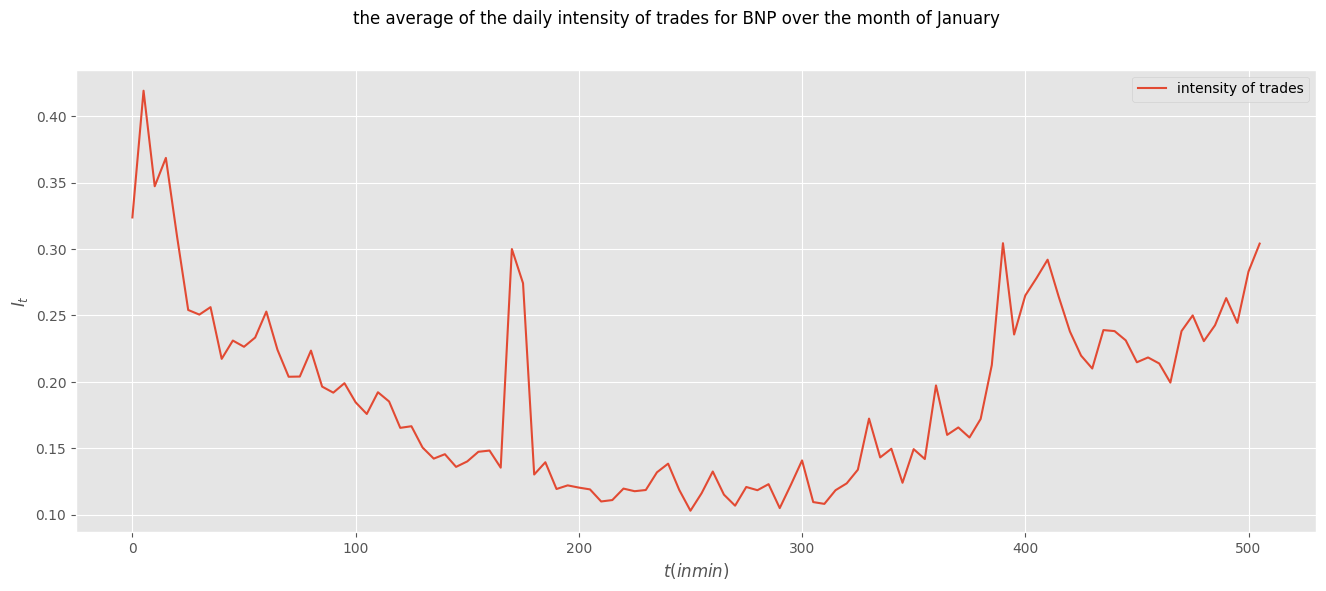

In [16]:
fig, ax = plt.subplots(figsize=(16,6))
fig.suptitle(r'the average of the daily intensity of trades for BNP over the month of January')


ax.plot(data_lamda['time'],data_lamda['intensity'].values,label=r'intensity of trades') #,where='post'
ax.set_xlabel(r'$t (in min)$')
ax.set_ylabel(r'$I_t$')
ax.legend()
plt.show()

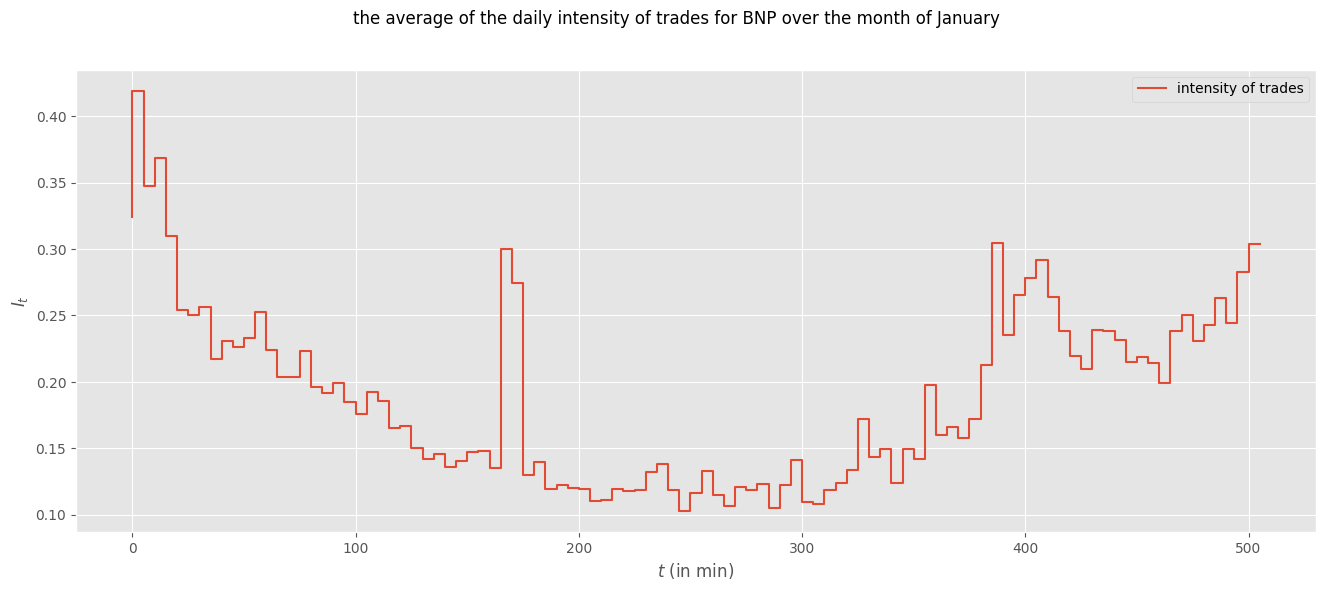

In [17]:
fig, ax = plt.subplots(figsize=(16,6))
fig.suptitle(r'the average of the daily intensity of trades for BNP over the month of January')


ax.step(data_lamda['time'],data_lamda['intensity'].values,label=r'intensity of trades') #,where='post'
ax.set_xlabel(r'$t$ (in min)')
ax.set_ylabel(r'$I_t$')
ax.legend()

plt.show()

2.2  Simulate a Poisson process with this fitted piecewise-constant intensity. Compare the empirical and simulated distributions of durations : densities, cdf, complementary cdf and quantile plots.


In [18]:
T = data_lamda['time'].max()*60 #Simulate during in seconds
jump_time = simulate_none_homogeneous_Poison(data=data_lamda,T=T)
jump_time = np.concatenate([[0],jump_time])
simulated_duration = np.array(get_differences(jump_time))
simulated_duration = simulated_duration*1000 # Convert to ms

**densities**

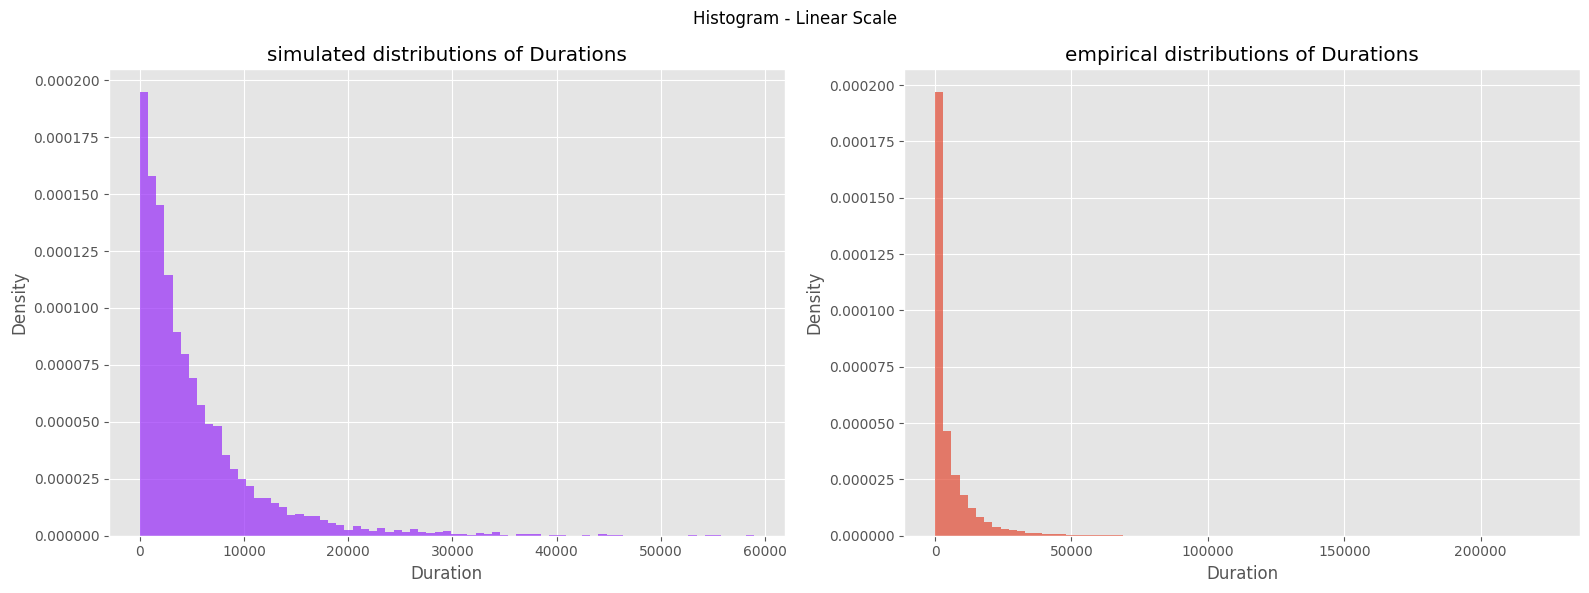

In [19]:
fig, ax = plt.subplots(1,2,figsize=(16,6))
fig.suptitle(r'Histogram - Linear Scale')


ax[0].hist(simulated_duration, bins=75, density=True, color='#972AF8', alpha=0.7)
ax[0].set_title('simulated distributions of Durations')
ax[0].set_xlabel('Duration')
ax[0].set_ylabel('Density')

ax[1].hist(Duration_values, bins=75, density=True,  alpha=0.7) #color='#972AF8'
ax[1].set_title('empirical distributions of Durations')
ax[1].set_xlabel('Duration')
ax[1].set_ylabel('Density')


plt.tight_layout()
plt.show()

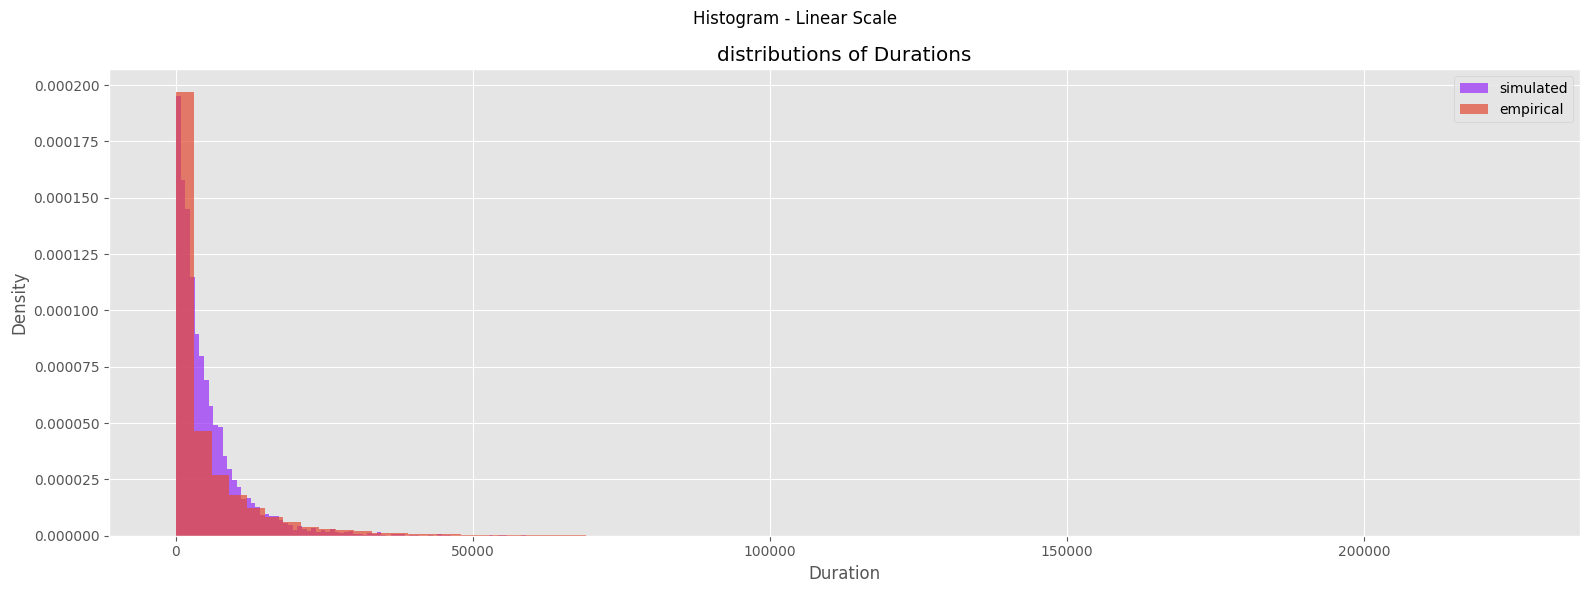

In [20]:
fig, ax = plt.subplots(figsize=(16,6))
fig.suptitle(r'Histogram - Linear Scale')



ax.set_title('distributions of Durations')
ax.set_xlabel('Duration')
ax.set_ylabel('Density')
ax.hist(simulated_duration, bins=75, density=True, color='#972AF8', alpha=0.7,label='simulated')
ax.hist(Duration_values, bins=75, density=True,  alpha=0.7,label='empirical') #color='#972AF8'
ax.legend()


plt.tight_layout()
plt.show()

Calculating best minimal value for power law fit
C:\Users\mohamed iyadh laouej\AppData\Roaming\Python\Python39\site-packages\powerlaw.py:692: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
Calculating best minimal value for power law fit


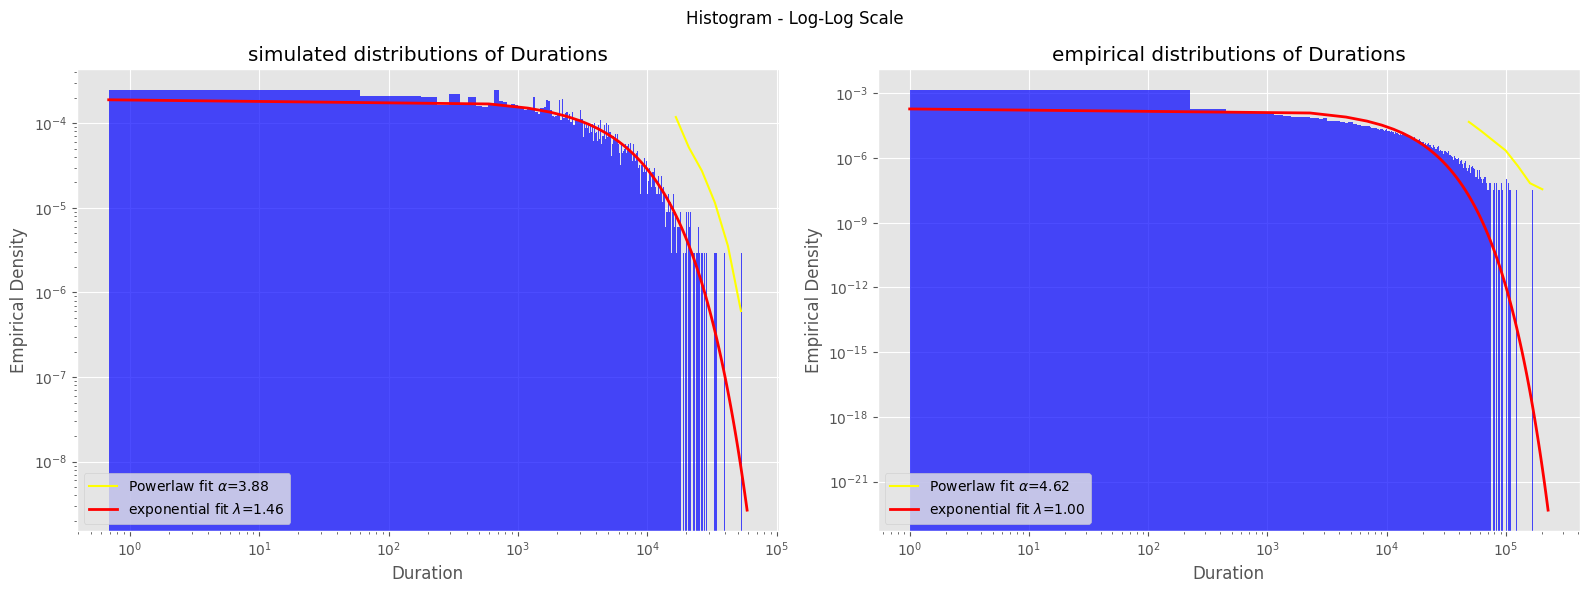

In [21]:
fig, ax = plt.subplots(1,2,figsize=(16,6))
fig.suptitle(r'Histogram - Log-Log Scale')

params= expon.fit(simulated_duration)
xmin, xmax = np.min(simulated_duration), np.max(simulated_duration)
x = np.linspace(xmin, xmax, 100)
p = expon.pdf(x, *params)

fit = pl.Fit(simulated_duration)
fit.plot_pdf(color='yellow', ax=ax[0],label=r'Powerlaw fit $\alpha$='+f'{fit.power_law.alpha:.2f}')
ax[0].hist(simulated_duration, bins=1000, density=True, log=True, color='blue', alpha=0.7)
ax[0].plot(x, p, linewidth=2,color='red',label=r'exponential fit $\lambda$='+f'{1/params[0]:.2f}')
ax[0].set_xscale('log')
ax[0].set_title('simulated distributions of Durations')
ax[0].set_xlabel('Duration')
ax[0].set_ylabel('Empirical Density')
ax[0].legend()

params= expon.fit(Duration_values)
xmin, xmax = np.min(Duration_values), np.max(Duration_values)
x = np.linspace(xmin, xmax, 100)
p = expon.pdf(x, *params)

fit = pl.Fit(Duration_values)
fit.plot_pdf(color='yellow', ax=ax[1],label=r'Powerlaw fit $\alpha$='+f'{fit.power_law.alpha:.2f}')
ax[1].hist(Duration_values, bins=1000, density=True, log=True, color='blue', alpha=0.7)
ax[1].plot(x, p, linewidth=2,color='red',label=r'exponential fit $\lambda$='+f'{1/params[0]:.2f}')
ax[1].set_xscale('log')
ax[1].set_title('empirical distributions of Durations')
ax[1].set_xlabel('Duration')
ax[1].set_ylabel('Empirical Density')
ax[1].legend()


plt.tight_layout()
plt.show()

We notice that by fitting a **Power low** distribution that the *real data* have a heavier tail compared to the *Simulated data* still It is still a good approximation. 

**cdf**

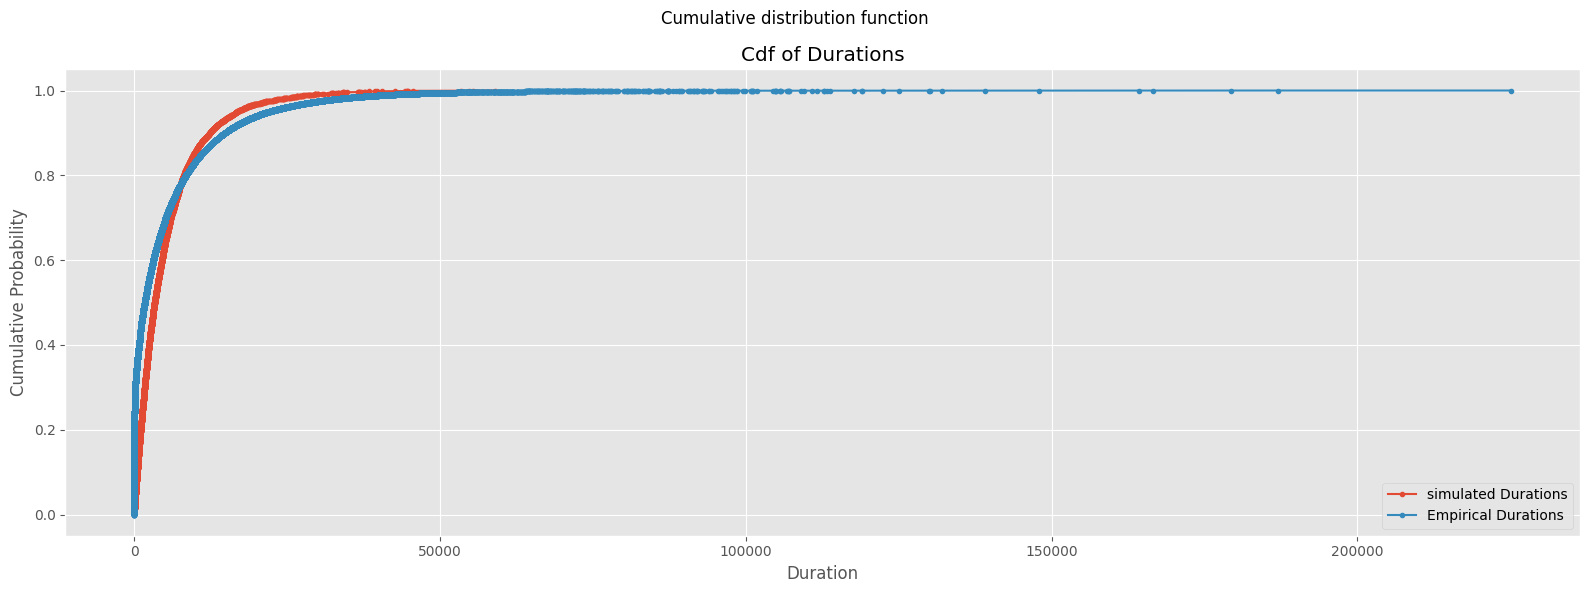

In [22]:
fig, ax = plt.subplots(figsize=(16,6))
fig.suptitle(r'Cumulative distribution function')

sorted_simulated_duration = np.sort(simulated_duration)
n = sorted_simulated_duration.size
cdf = np.arange(1, n + 1) / n

ax.plot(sorted_simulated_duration, cdf, marker='.', label='simulated Durations')

sorted_Duration_values = np.sort(Duration_values)
n = sorted_Duration_values.size
cdf = np.arange(1, n + 1) / n

ax.plot(sorted_Duration_values, cdf, marker='.', label='Empirical Durations')
ax.set_title('Cdf of Durations')
ax.set_xlabel('Duration')
ax.set_ylabel('Cumulative Probability')
ax.legend()

plt.tight_layout()
plt.show()

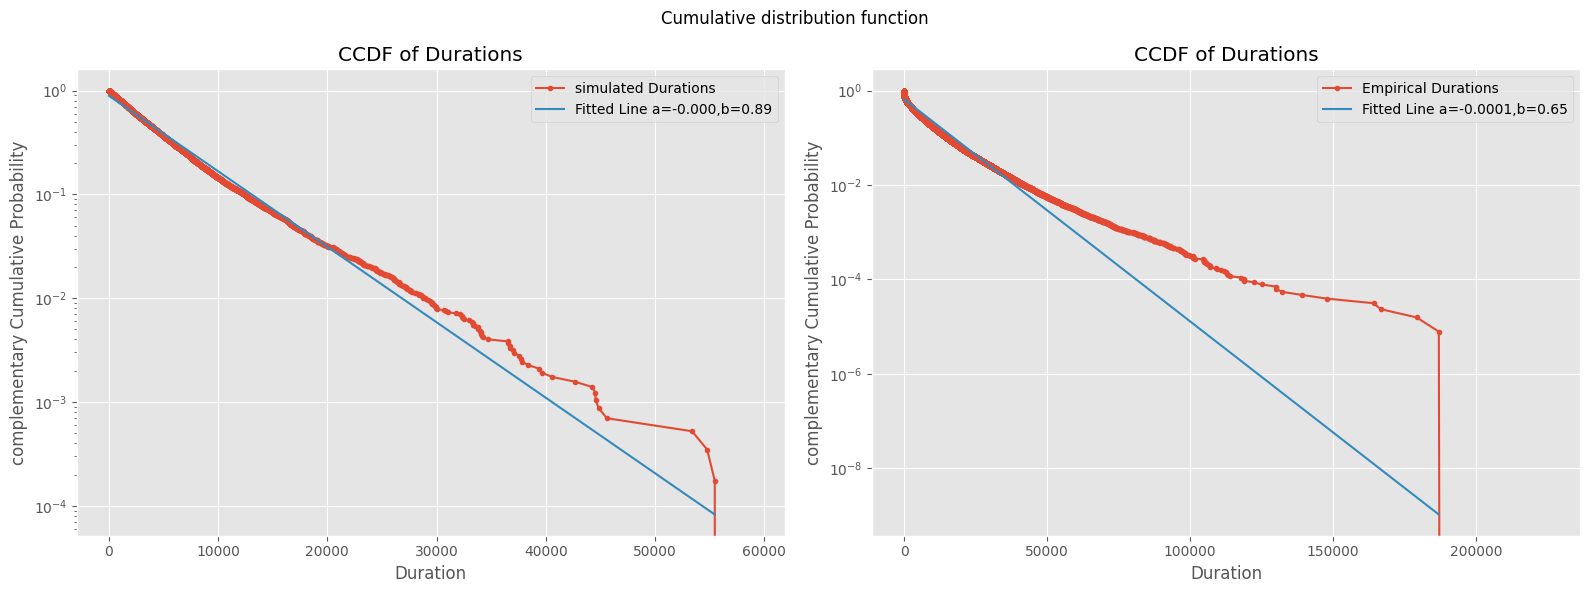

In [23]:
fig, ax = plt.subplots(1,2,figsize=(16,6))
fig.suptitle(r'Cumulative distribution function')

sorted_simulated_duration = np.sort(simulated_duration)
n = sorted_simulated_duration.size
cdf = np.arange(1, n + 1) / n

# Perform linear regression
eligble = np.where(1-cdf>1e-7)
slope, intercept, r_value, p_value, std_err = linregress(sorted_simulated_duration[eligble], np.log((1-cdf)[eligble]))
x_fit = np.linspace(min(sorted_simulated_duration[eligble]), max(sorted_simulated_duration[eligble]), 100)
y_fit = np.exp(intercept + slope * x_fit)

ax[0].plot(sorted_simulated_duration, 1-cdf, marker='.', label='simulated Durations')
ax[0].plot(x_fit, y_fit, label=f'Fitted Line a={slope:.3f},b={np.exp(intercept):.2f}')
ax[0].set_title('CCDF of Durations')
ax[0].set_xlabel('Duration')
ax[0].set_ylabel('complementary Cumulative Probability')
ax[0].legend()
ax[0].set_yscale('log')

sorted_Duration_values = np.sort(Duration_values)
n = sorted_Duration_values.size
cdf = np.arange(1, n + 1) / n

# Perform linear regression
eligble = np.where(1-cdf>1e-7)
slope, intercept, r_value, p_value, std_err = linregress(sorted_Duration_values[eligble], np.log((1-cdf)[eligble]))
x_fit = np.linspace(min(sorted_Duration_values[eligble]), max(sorted_Duration_values[eligble]), 100)
y_fit = np.exp(intercept + slope * x_fit)

ax[1].plot(sorted_Duration_values, 1-cdf, marker='.', label='Empirical Durations')
ax[1].plot(x_fit, y_fit, label=f'Fitted Line a={slope:.4f},b={np.exp(intercept):.2f}')
ax[1].set_title('CCDF of Durations')
ax[1].set_xlabel('Duration')
ax[1].set_ylabel('complementary Cumulative Probability')
ax[1].legend()
ax[1].set_yscale('log')



plt.tight_layout()
plt.show()

**Quantile plots**

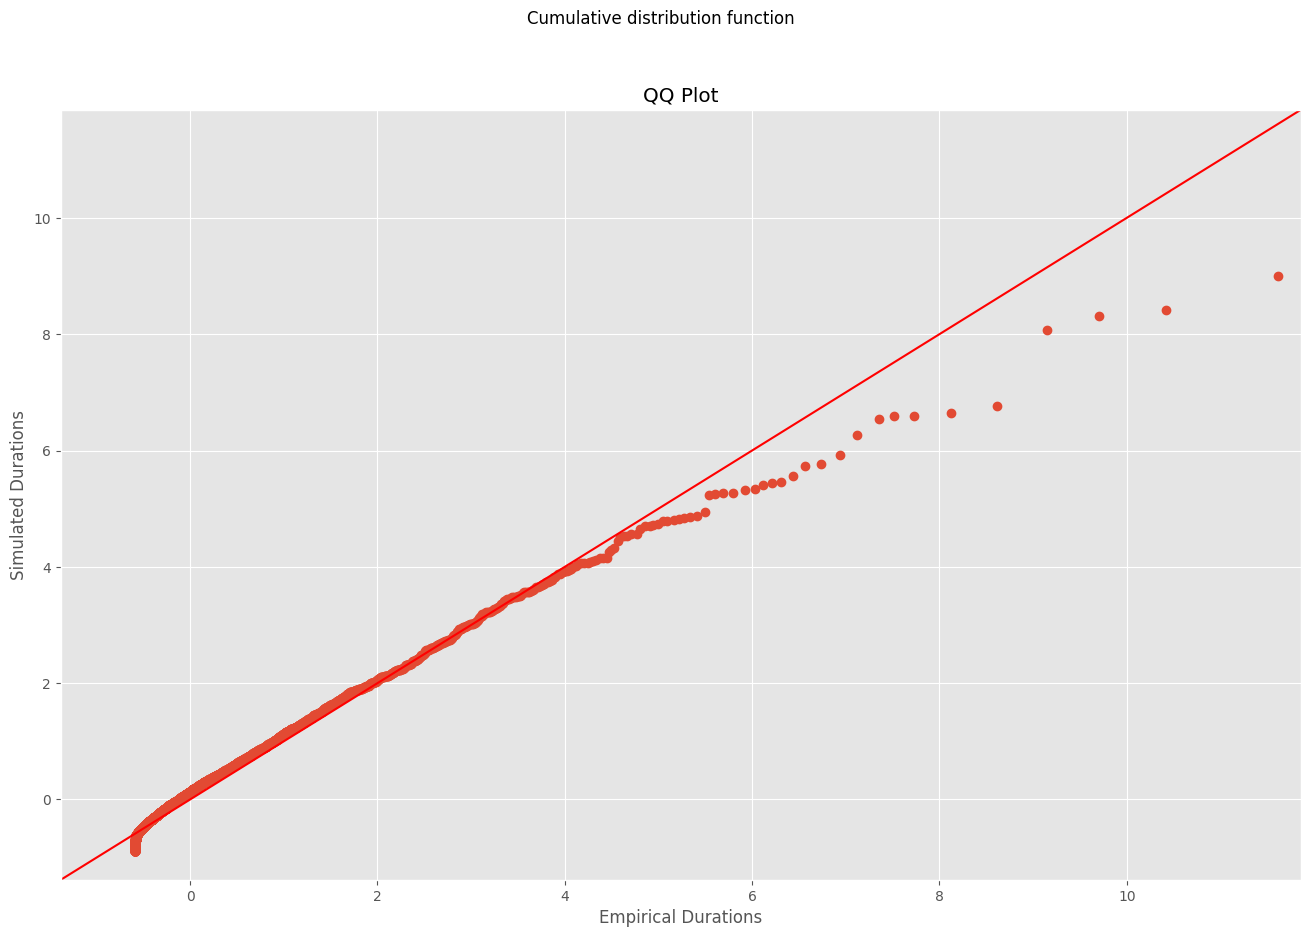

In [24]:
fig, ax = plt.subplots(figsize=(16,10))
fig.suptitle(r'Cumulative distribution function')

sim1_norm = (sorted_Duration_values - np.mean(sorted_Duration_values)) / np.std(sorted_Duration_values)
sim2_norm = (sorted_simulated_duration - np.mean(sorted_simulated_duration)) / np.std(sorted_simulated_duration)

sm.qqplot_2samples(sim1_norm, sim2_norm, line ='45',ax=ax)
#sm.qqplot_2samples(sorted_Duration_values, sorted_simulated_duration, line ='45',ax=ax)

# Add titles and labels
ax.set_title('QQ Plot')
ax.set_xlabel('Empirical Durations')
ax.set_ylabel('Simulated Durations')
ax.grid(True)

# Show the plot

plt.show()


We notice that by fitting a **QQ plot** that the empirical distribution has a heavier tail compared to the simulated data. 

2.3 Using the time change theorems, comment on the goodness-of-fit of a non-homogeneous Poisson process for trades.

In [25]:
lamda_jump = np.array([integrate_piecewise_constant_function(data_lamda[['time in s','intensity']], s) for s in jump_time])
lamda_simulated_duration = np.array(get_differences(lamda_jump))

In [26]:
sample = 1*lamda_simulated_duration
ks_statistic, p_value = perform_ks_test(sample)

print("Kolmogorov-Smirnov Test:")
print("KS Statistic:", f'{ks_statistic:.4f}')
print("p-value:", f'{p_value:.2%}')
if p_value < 0.05:
    print("Reject null hypothesis: Sample does not follow an exponential distribution")
else:
    print("Fail to reject null hypothesis: Sample follows an exponential distribution")

Kolmogorov-Smirnov Test:
KS Statistic: 0.0097
p-value: 64.88%
Fail to reject null hypothesis: Sample follows an exponential distribution


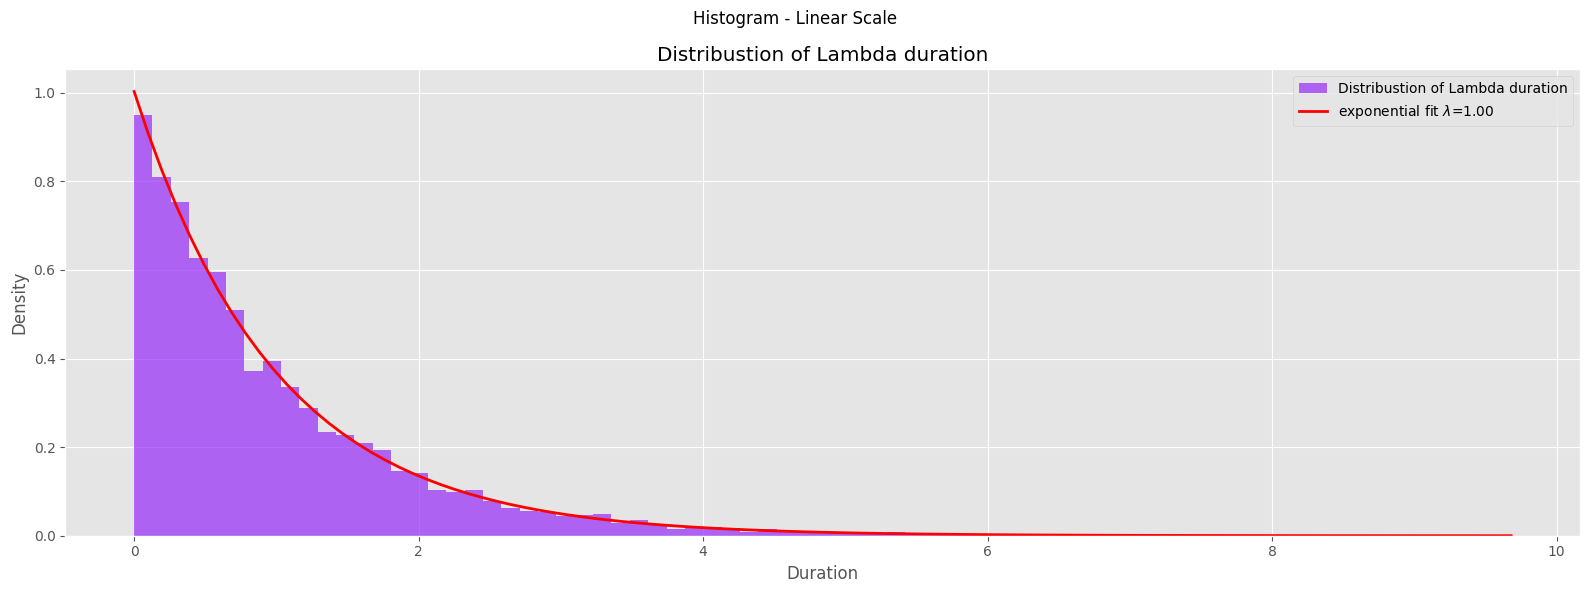

In [27]:
fig, ax = plt.subplots(figsize=(16,6))
fig.suptitle(r'Histogram - Linear Scale')

params= expon.fit(lamda_simulated_duration)
xmin, xmax = np.min(lamda_simulated_duration), np.max(lamda_simulated_duration)
x = np.linspace(xmin, xmax, 100)
p = expon.pdf(x, *params)

ax.hist(lamda_simulated_duration, bins=75, density=True, color='#972AF8', alpha=0.7,label=r'Distribustion of Lambda duration')
ax.plot(x, p, linewidth=2,color='red',label=r'exponential fit $\lambda$='+f'{params[1]:.2f}')
ax.set_title('Distribustion of Lambda duration')
ax.set_xlabel('Duration')
ax.set_ylabel('Density')
ax.legend()

plt.tight_layout()
plt.show()

$(\Lambda(S_i)-\Lambda(S_{i-1}))_{i \in [[1,n]]}$ has an exponential distribition for parameter $\lambda=1$. Time change theorem is respected.